In [5]:
# Run once
!pip install -q scikit-learn pandas nltk matplotlib joblib transformers

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
# Use the upload widget and pick your CSV (e.g., sentiment_dataset.csv)
from google.colab import files
uploaded = files.upload()  # click "Choose Files" and upload the CSV from your machine

import io, pandas as pd
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))
df.head()


Saving sentiment_dataset.csv to sentiment_dataset.csv


,id,text,sentiment
0,1,"I love this product, it works perfectly!",positive
1,2,"Worst experience ever, totally disappointed.",negative
2,3,"The service was okay, nothing special.",neutral
3,4,Absolutely fantastic! Highly recommend it.,positive
4,5,"I hate waiting so long, terrible service.",negative


In [7]:
print("shape:", df.shape)
print(df['sentiment'].value_counts())
df['text'].sample(5).tolist()


shape: (30, 3)
sentiment
positive    11
negative    10
neutral      9
Name: count, dtype: int64


['Fantastic features and easy to use.',
 'Absolutely fantastic! Highly recommend it.',
 'Worst experience ever, totally disappointed.',
 'Very poor quality, I regret buying this.',
 'Amazing customer support, very helpful staff.']

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)          # remove urls
    text = re.sub(r'[^a-z\s]', ' ', text)                # keep letters only
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop and len(t) > 1]
    return " ".join(tokens)

# Create a cleaned text column
df['clean_text'] = df['text'].apply(preprocess)
df[['text','clean_text']].head()


,text,clean_text
0,"I love this product, it works perfectly!",love product work perfectly
1,"Worst experience ever, totally disappointed.",worst experience ever totally disappointed
2,"The service was okay, nothing special.",service okay nothing special
3,Absolutely fantastic! Highly recommend it.,absolutely fantastic highly recommend
4,"I hate waiting so long, terrible service.",hate waiting long terrible service


In [9]:
from sklearn.model_selection import train_test_split
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("train:", X_train.shape, "test:", X_test.shape)


train: (24,) test: (6,)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

    negative       0.50      0.50      0.50         2
     neutral       0.50      0.50      0.50         2
    positive       0.50      0.50      0.50         2

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.50         6
weighted avg       0.50      0.50      0.50         6



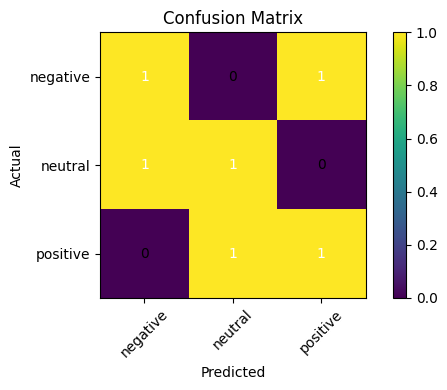

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
labels = clf.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(6,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
probs = clf.predict_proba(X_test_tfidf).max(axis=1)  # highest probability per sample
results = pd.DataFrame({
    'text': X_test.values,
    'true': y_test.values,
    'pred': y_pred,
    'confidence': probs
})
# Display all results since the test set is small
display(results)

,text,true,pred,confidence
0,amazing customer support helpful staff,positive,neutral,0.384947
1,bad could better,neutral,neutral,0.410120
2,absolutely fantastic highly recommend,positive,positive,0.437865
3,terrible app keep crashing time,negative,negative,0.400718
4,movie decent long,neutral,negative,0.400718
5,item broke one use waste money,negative,positive,0.437865


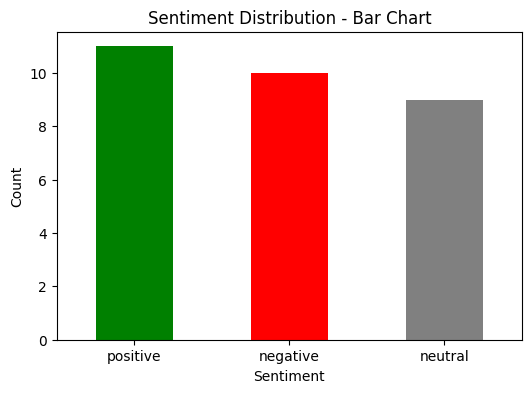

In [15]:
import matplotlib.pyplot as plt

# Count values
sent_counts = df['sentiment'].value_counts()

# Bar chart
plt.figure(figsize=(6,4))
sent_counts.plot(kind='bar', color=['green','red','gray'])
plt.title("Sentiment Distribution - Bar Chart")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


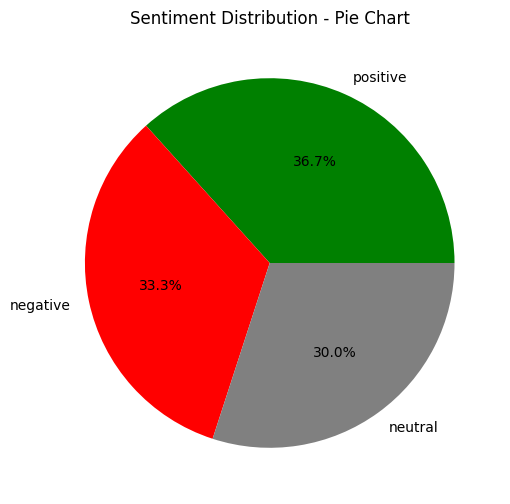

In [16]:
# Pie chart
plt.figure(figsize=(6,6))
sent_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green','red','gray'])
plt.title("Sentiment Distribution - Pie Chart")
plt.ylabel("")  # remove y-label for cleaner look
plt.show()
